<font size=6> Model soups </font>

В статье [Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time (2022) 🎓[arxiv]](https://arxiv.org/pdf/2203.05482.pdf) предложена интересная идея ансамблирования моделей, названная “суп моделей”. Она очень проста: **обучить несколько моделей** (для этого мы будем использовать **циклический отжиг**) и **агрегировать веса моделей**, которые соответствуют нескольким различным минимумам функции потерь, в одну модель.

# Подготовка данных и модели

Для “приготовления супа” возьмем датасет CIFAR-10.

In [ ]:
import random
import torch
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar = datasets.CIFAR10("CIFAR10", train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(
    "CIFAR10", train=False, download=True, transform=transform
)

train_set, val_set = random_split(cifar, [40_000, 10_000])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar_test, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 28386545.06it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


Соберем простую модель:

In [ ]:
import torch
import torch.nn as nn


class SimpleNet_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):  # input [batch, 3, 32, 32]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.pool(self.conv3(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Для обучения будем использовать `lightning`, для расчета метрик — `torchmetrics`. Это сделает код более универсальным (его можно использовать для ваших моделей с минимумом модификаций).

In [ ]:
!pip install -q lightning tbparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 31.8 MB/s eta 0:00:00


Для чтения логов будем использовать `tbparse`:

In [ ]:
import matplotlib.pyplot as plt
from tbparse import SummaryReader
from IPython.display import clear_output

def visualization(log_dir):
    # visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars.drop_duplicates()

    uniq = set(df.tag.unique())
    uniq.remove("epoch")
    uniq = list(uniq)
    uniq.sort()

    i = 0
    ax_dict = {}
    for item in uniq:
        metric = item.split("/")[0]
        if metric not in ax_dict:
            ax_dict[metric] = i
            i += 1

    fig, axs = plt.subplots(len(ax_dict), 1, figsize=(12, 3.5 * len(ax_dict)))
    for item in uniq:
        metric = item.split("/")[0]
        ax = axs[ax_dict[metric]]
        sub_df = df[df["tag"] == item]
        ax.plot(sub_df.step, sub_df.value, label=item)
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_xlabel("iter")
    plt.show()

# Реализация супа моделей в коде

Есть [несколько подходов 🎓[arxiv]](https://arxiv.org/pdf/2203.05482.pdf) к “приготовлению супа”. Мы рассмотрим два:

**Uniform soup** (равномерный суп) — веса всех моделей суммируются с одинаковым весом:
$$\text{Model} = f(x, \frac{1}{k}\sum_{i=1}^{k}ϴ_i)$$

**Greedy soup** (жадный суп):
1. Модели сортируются по убыванию качества на валидационной (не на тестовой!!!) выборке.
2. Лучшая модель становится первым “ингредиентом” супа. Текущее качество “супа” определяется по значению метрики лучшей модели на валидационной (не на тестовой!!!) выборке.
3. Остальные отсортированные модели по очереди добавляются в суп. Качество новой модели определяется по значению метрики на валидационной (не на тестовой!!!) выборке. Если значение метрики новой модели лучше текущего качества супа, то модель добавляется в “суп”, а текущая метрика обновляется.

Качество “супа” определяется по тестовой выборке.

Код для методов реализован ниже. Для обучения отдельных моделей используется циклический отжиг.

In [ ]:
!mkdir ./soup_models_weights

In [ ]:
import lightning as L
from pathlib import Path
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassAUROC,
)


class MakeSoup(L.LightningModule):
    def __init__(
        self,
        model,
        num_class,
        n_cycle_iter,
        cycle_epochs,
        show=True,
        soup_path = "./soup_models_weights"
    ):
        super().__init__()
        self.cycle_epochs = cycle_epochs
        self.num_class = num_class
        self.n_cycle_iter = n_cycle_iter
        self.model = model
        self.show = show

        self.criterion = torch.nn.CrossEntropyLoss()

        # set metrics
        self.metrics = MetricCollection([
            MulticlassAccuracy(num_classes=num_class,),
            # MulticlassF1Score(num_classes=num_class,),
            # MulticlassAUROC(num_classes=num_class,)
        ])

        self.train_metrics = self.metrics.clone(postfix='/train')
        self.val_metrics = self.metrics.clone(postfix='/val')
        self.models_data = []
        self.soup_path = Path(soup_path)


    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=0.01,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=self.n_cycle_iter,
            eta_min=0,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # or 'epoch'
                "frequency": 1,
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        self.log(
            "loss/train", loss, prog_bar=True, on_epoch=True, on_step=False
        )
        self.train_metrics.update(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log(
            "loss/val", loss, prog_bar=True, on_epoch=True, on_step=False
        )
        self.val_metrics.update(y_hat, y)

    def on_validation_epoch_end(self):
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        if self.trainer.ckpt_path is not None:
            self.models_data.append({
                "path": self.trainer.ckpt_path,
                "metrics": {
                   key: val.cpu().item() for key, val in val_metrics.items()
                }
            })

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        if self.show and self.current_epoch != 0:
            visualization(self.logger.log_dir)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        self.metrics.update(y_hat, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        predict = y_hat.argmax(dim=1).detach().cpu()
        true = y.detach().cpu()

        return {
            "predict_label": predict,
            "true_label": true,
            }

    def uniform_soup(self, skip_first=False):
        self.models_data.sort(key=lambda x: x["path"], reverse=True)
        if skip_first:
            models_data = self.models_data[1:].copy()
        else:
            models_data = self.models_data.copy()
        n_model = len(models_data)
        for i, item in enumerate(models_data):
            checkpoint = torch.load(item["path"], map_location=self.device)["state_dict"]
            state_dict = {
                key.removeprefix("model."): val
                for key, val in checkpoint.items()
            }
            if i == 0:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model))
                    for key, val in state_dict.items()
                }
            else:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) + uniform_soup_params[key]
                    for key, val in state_dict.items()
                }
            print(f'Adding {item["path"]} to soup.')
        self.model.load_state_dict(uniform_soup_params)
        path = self.soup_path / "model_uniform_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

    def greedy_soup(self, val_loader, metric="MulticlassAccuracy"):
        # sort
        self.models_data.sort(key=lambda x: x["metrics"][metric+"/val"], reverse=True)

        best_model_path = self.models_data[0]["path"]
        best_score = self.models_data[0]["metrics"][metric+"/val"]

        greedy_soup_ingredients = [best_model_path]

        checkpoint = torch.load(
            best_model_path, map_location=self.device
        )["state_dict"]

        greedy_soup_params = {
                key.removeprefix("model."): val
                for key, val in checkpoint.items()
        }

        for i in range(1, len(self.models_data)):
            n = len(greedy_soup_ingredients)
            path = self.models_data[i]["path"]

            checkpoint = torch.load(
                path, map_location=self.device
            )["state_dict"]

            ingredient_params = {
                key.removeprefix("model."): val
                for key, val in checkpoint.items()
            }

            # mix ingredient
            potential_greedy_soup_params = {
                k: greedy_soup_params[k].clone() * (n / (n + 1.0))
                + ingredient_params[k].clone() * (1.0 / (n + 1.0))
                for k in ingredient_params
            }

            self.val_metrics.reset()
            self.model.load_state_dict(potential_greedy_soup_params)
            # validate
            with torch.inference_mode():
                for batch_idx, batch in enumerate(val_loader):
                    self.test_step(batch, batch_idx)
                score = self.metrics.compute()[metric]
                self.metrics.reset()

            if score > best_score:
                greedy_soup_ingredients.append(path)
                best_score = score
                greedy_soup_params = potential_greedy_soup_params
                print(
                    f"Adding to soup. New soup is {greedy_soup_ingredients}. ",
                    f"With score = {best_score}",
                )

        self.model.load_state_dict(greedy_soup_params)
        path = self.soup_path /  "model_greedy_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

# Обучение моделей

Параметры обучения представлены ниже. Запуск обучения закомментирован. Обучение модели занимает примерно 30 минут на GPU.

In [ ]:
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

L.seed_everything(42)

n_model = 5
cycle_epochs = 20
num_class = 10

set_random_seed(42)
model = SimpleNet_CIFAR()

n_cycle_iter = cycle_epochs * len(train_loader)

pl_model = MakeSoup(model, num_class, n_cycle_iter, cycle_epochs)

lr_monitor = LearningRateMonitor(logging_interval='step')
save_checkpoint = ModelCheckpoint(
    every_n_epochs=cycle_epochs,
    save_top_k=n_model,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

trainer = L.Trainer(
    max_epochs=cycle_epochs * n_model,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log/"),
    callbacks=[lr_monitor, save_checkpoint],
)

# trainer.fit(pl_model, train_loader, val_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Для ускорения работы мы загрузим заранее обученные модели и логи обучения:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-additions/MS/model_soup_log.zip
!unzip -qq model_soup_log.zip

Загрузим модели, посчитаем статистику по предсказаниям и точность на выборке для валидации и загрузим последнее в нужное поле модели. Посмотрим на логи обучения.

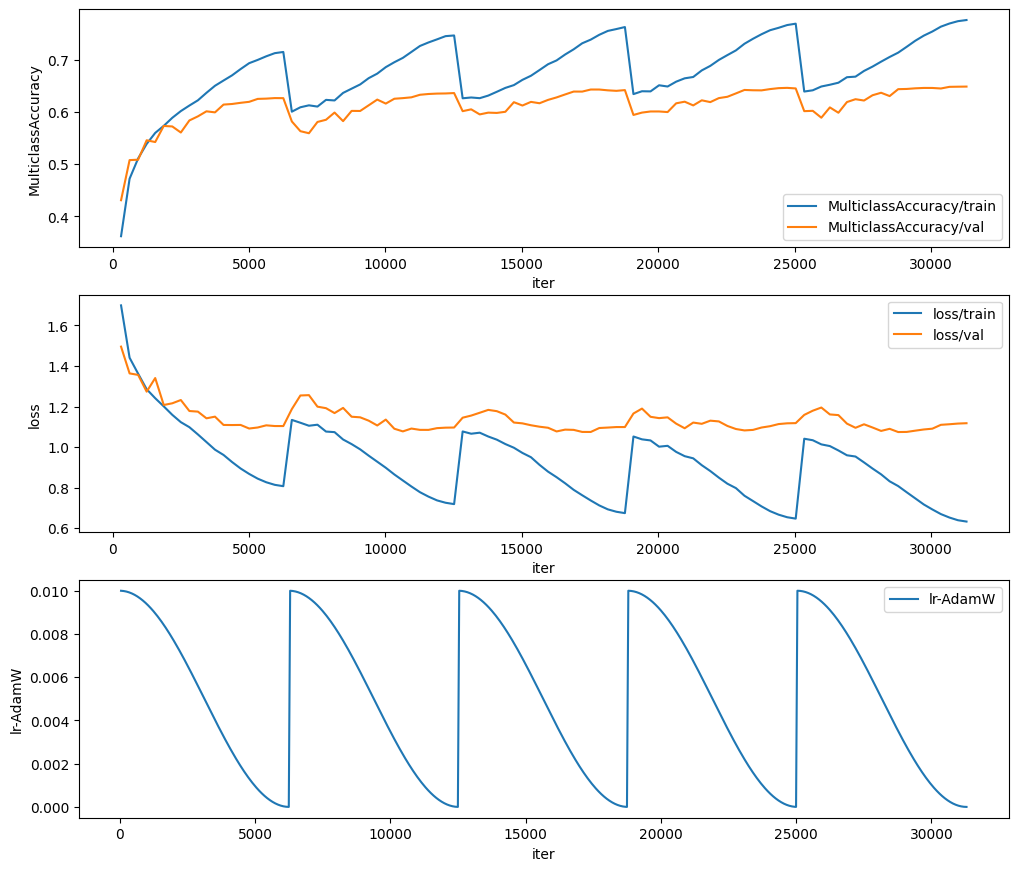

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │     0.635899007320404     │
│         loss/val          │    1.0963464975357056     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6415534615516663     │
│         loss/val          │    1.0986661911010742     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │     0.644766092300415     │
│         loss/val          │    1.1180671453475952     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6482957005500793     │
│         loss/val          │    1.1176204681396484     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6261476278305054     │
│         loss/val          │    1.1035901308059692     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
import os

visualization("/content/model_soup_log/log/lightning_logs/version_0")
weights_path = Path(
    "/content/model_soup_log/log/lightning_logs/version_0/checkpoints/"
)
file_list = os.listdir(weights_path)
file_list.sort()

for f in file_list:
    path = weights_path / f

    trainer.validate(
        model=pl_model,
        dataloaders=val_loader,
        ckpt_path=path,
    )

Мы сохранили пути до моделей и их точность:

In [ ]:
pl_model.models_data

[{'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.635899007320404}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6415534615516663}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.644766092300415}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6482957005500793}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6261476278305054}}]

Посчитаем точность для наших моделей на тестовой выборке:

In [ ]:
for f in file_list:
    path = weights_path / f

    trainer.test(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6317999958992004     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6402999758720398     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6462000012397766     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6441000699996948     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6267000436782837     │
└───────────────────────────┴───────────────────────────┘

Лучшая модель имеет точность $64.62\%$.

# Сравнение ансамблирования моделей и супа моделей

Посчитаем точность на тестовой выборке в случае голосования моделей (выбирается класс, за который проголосовало большинство).

In [ ]:
import numpy as np


ans_statistic = np.zeros((n_model, len(cifar_test)))
true_label = np.zeros((len(cifar_test)))

for i, f in enumerate(file_list):
    path = weights_path / f

    prediction=trainer.predict(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )
    batch_size = prediction[0]["predict_label"].shape[0]
    for batsh_idx, items in enumerate(prediction):
        ans_statistic[
            i, batch_size*batsh_idx: batch_size*(batsh_idx+1)
        ] = items["predict_label"].numpy()
        true_label[
            batch_size*batsh_idx: batch_size*(batsh_idx+1)
        ] = items["true_label"].numpy()

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Визуализируем предсказание наших $5$ моделей для первых $100$ объектов тестовой выборки. Убедимся, что модели дают разные ответы, а значит их можно использовать для ансамбля.

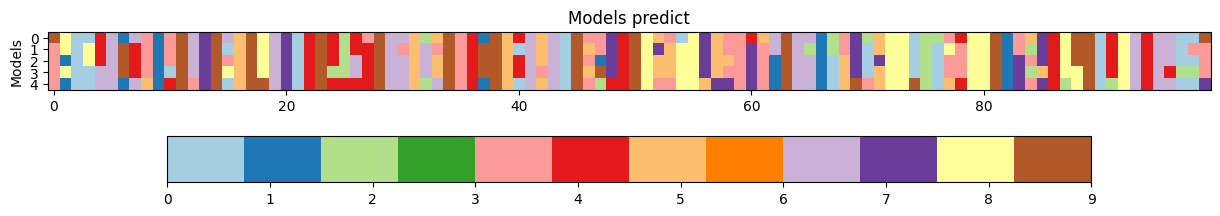

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(ans_statistic[:, :100], cmap="Paired")
plt.colorbar(orientation="horizontal")
plt.title("Models predict")
plt.ylabel("Models")
plt.yticks(range(5))
plt.show()

In [ ]:
predict_label = np.zeros((len(cifar_test)))
for i in range(len(cifar_test)):
    values, counts = np.unique(ans_statistic[:, i], return_counts=True)
    predict_label[i] = values[counts.argmax()]
predict_label

array([3., 8., 0., ..., 5., 0., 7.])

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Ensemble accuracy {accuracy_score(true_label, predict_label)}")

Ensemble accuracy 0.6567


Голосование моделей дает точность $65.67\%$. На $1.05\%$ лучше лучшей модели, но при этом на $1$ предсказание уходит в $5$ раз больше вычислительных ресурсов.

Попробуем применить `uniform_soup`:

In [ ]:
model = pl_model.uniform_soup()
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6455999612808228     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6455999612808228}]

Точность хуже. Посмотрим на наши модели: первая модель имеет точность ниже, чем остальные. Это связано с тем, что она стартовала с худшей позиции.

Уберем эту модель из супа:

In [ ]:
model = pl_model.uniform_soup(skip_first=True)
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6483999490737915     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6483999490737915}]

Получили точность $64.84\%$. На $0.22\%$ лучше, чем у лучшей модели и на $0.83\%$ меньше, чем у голосования. При этом модель прогоняется только $1$ раз.

Попробуем `greedy_soup`:

In [ ]:
model = pl_model.greedy_soup(val_loader)
trainer.test(pl_model, test_loader)

Adding to soup. New soup is [PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'), PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt')].  With score = 0.6521247029304504


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6484999656677246     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6484999656677246}]

Получили точность $64.85\%$. Это на $0.23\%$ лучше лучшей модели и на $0.82\%$ хуже голосования. При этом модель прогоняется только $1$ раз.



Таким образом, суп моделей является альтернативой ансамблированию методом голосования, позволяющей поднять точность предсказания без увеличения необходимых для Inference вычислительных ресурсов.